In [1]:
import warnings

import matplotlib.pyplot as plt

import os.path as osp

from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from src.datasets import DatasetBuilder
from src.models import BetaVAE, Annealer
from src.models.lightning_wrappers import VAELightningWrapper  
from src.utils.generic_utils import seed_everything, get_config, load_model_weights, evaluate_classification_model

d:\PycharmProjects\CF-Robustness-Benchmark\venv\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Load a configuration file

In [2]:
config_path = r"D:\PycharmProjects\CF-Robustness-Benchmark\configs\train_vae_mnist.yaml"
config = get_config(config_path)

## Load the dataset

In [3]:
ds_builder = DatasetBuilder(config)
ds_builder.setup()
train_loader, val_loader, test_loader = ds_builder.get_dataloaders()

In [4]:
class_names = ds_builder.class_encodings

## Build the model

In [5]:
vae = BetaVAE(**config.model.args,
              input_size=(config.data.img_size, config.data.img_size))

In [6]:
lwrapper = VAELightningWrapper(config, vae)

In [7]:
img,  _ = next(iter(train_loader))
img.shape

torch.Size([64, 1, 28, 28])

In [8]:
experiment_dir = r"D:\PycharmProjects\CF-Robustness-Benchmark\notebooks\experiments"
experiment_name = "mnist_vae"
experiment_version = "binary"  if config.data.num_classes == 2 else "multiclass"
checkpints_dir = osp.join(experiment_dir, experiment_name, experiment_version, 'checkpoints')
classes4fname = ("_").join([str(i) for i in class_names.values()]) if config.data.num_classes == 2 else ""


chekpoint_callback = ModelCheckpoint(
    monitor="train_total",
    dirpath=checkpints_dir,
    filename=f"{config.data.flag}_{classes4fname}_{{epoch:02d}}_{{total_loss:.2f}}",
    save_top_k=1,
    mode="min",
    save_weights_only=True,
)
chekpoint_callback.FILE_EXTENSION = '.pth'

tb_logger = TensorBoardLogger(save_dir=experiment_dir, name=experiment_name, version=experiment_version)

trainer = Trainer(
    log_every_n_steps=10,
    max_epochs=15,
    enable_checkpointing=True,
    callbacks=[chekpoint_callback],
    logger=tb_logger
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


d:\PycharmProjects\CF-Robustness-Benchmark\venv\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory D:\PycharmProjects\CF-Robustness-Benchmark\notebooks\experiments\mnist_vae\binary\checkpoints exists and is not empty.

  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | BetaVAE | 419 K  | train
1 | loss  | BCELoss | 0      | train
------------------------------------------
419 K     Trainable params
0         Non-trainable params
419 K     Total params
1.679     Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

d:\PycharmProjects\CF-Robustness-Benchmark\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


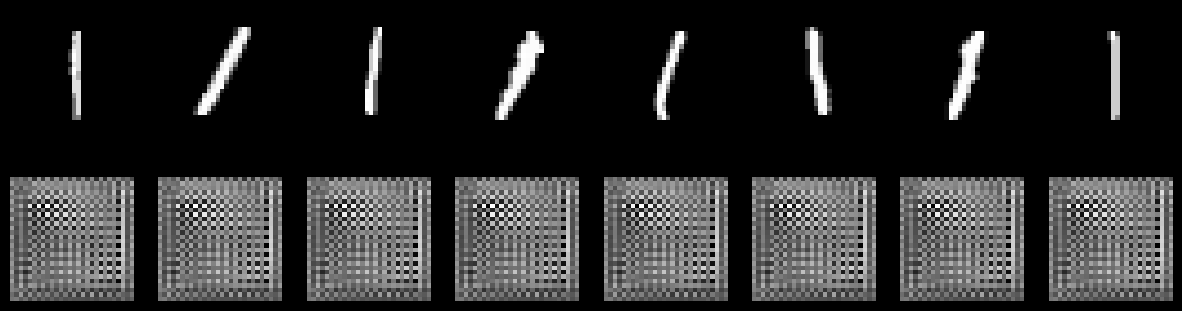

d:\PycharmProjects\CF-Robustness-Benchmark\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 163/163 [00:16<00:00,  9.85it/s, v_num=nary, train_total_step=2.53e+3, train_recon_step=2.5e+3, train_kld_step=29.80] 

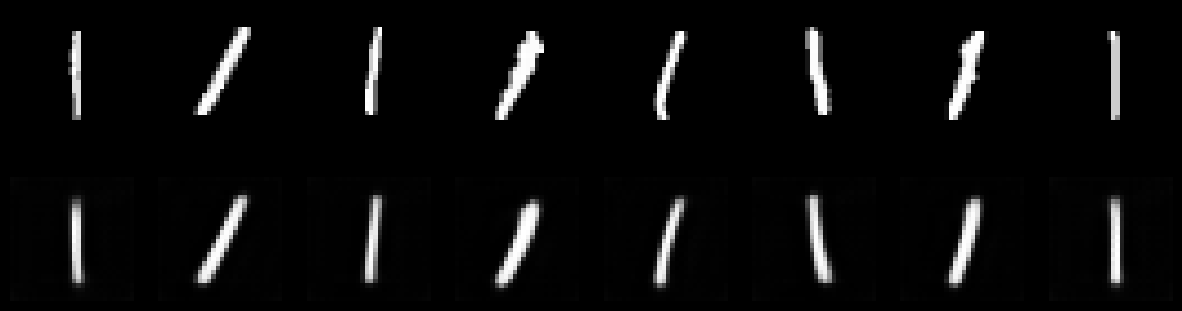

Epoch 1: 100%|██████████| 163/163 [00:18<00:00,  8.90it/s, v_num=nary, train_total_step=2e+3, train_recon_step=1.97e+3, train_kld_step=31.20, train_total_epoch=8.71e+3, train_recon_epoch=8.66e+3, train_kld_epoch=46.90]   

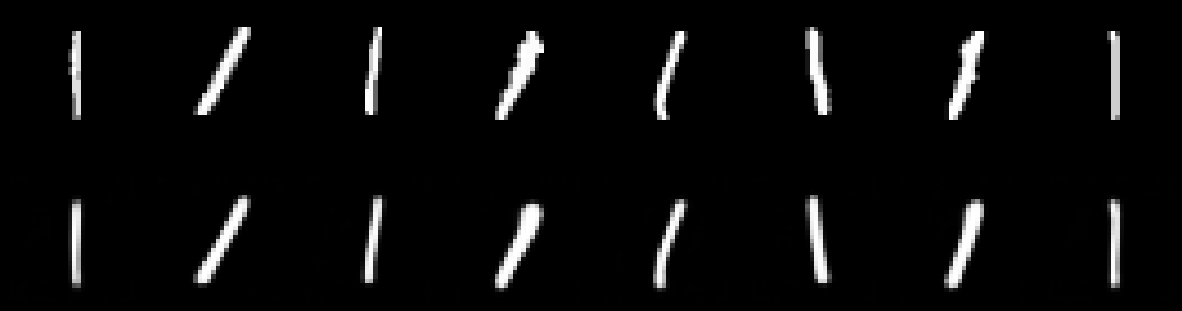

Epoch 2: 100%|██████████| 163/163 [00:19<00:00,  8.20it/s, v_num=nary, train_total_step=1.93e+3, train_recon_step=1.9e+3, train_kld_step=30.80, train_total_epoch=3.54e+3, train_recon_epoch=3.49e+3, train_kld_epoch=50.50] 

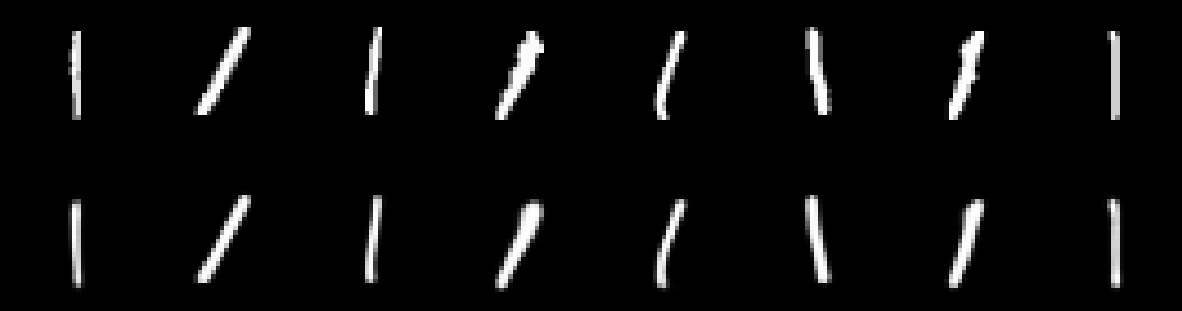

Epoch 3: 100%|██████████| 163/163 [00:18<00:00,  8.67it/s, v_num=nary, train_total_step=1.79e+3, train_recon_step=1.76e+3, train_kld_step=29.80, train_total_epoch=3.14e+3, train_recon_epoch=3.09e+3, train_kld_epoch=51.10]

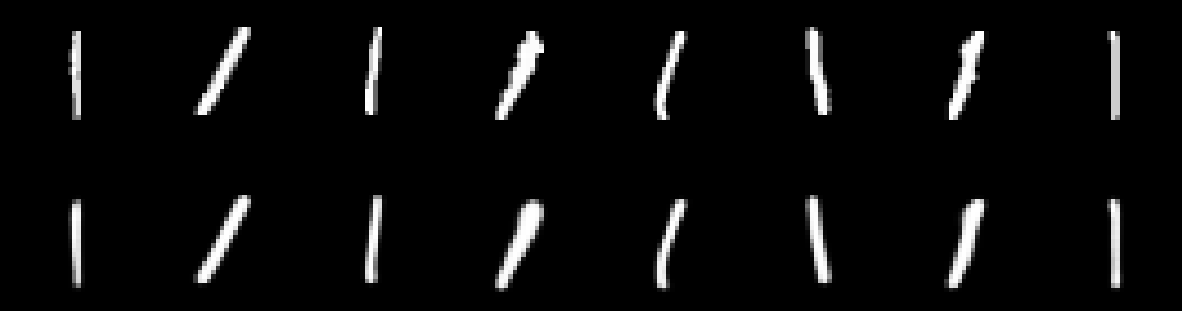

Epoch 4: 100%|██████████| 163/163 [00:18<00:00,  8.83it/s, v_num=nary, train_total_step=1.6e+3, train_recon_step=1.57e+3, train_kld_step=29.50, train_total_epoch=2.95e+3, train_recon_epoch=2.9e+3, train_kld_epoch=51.10]  

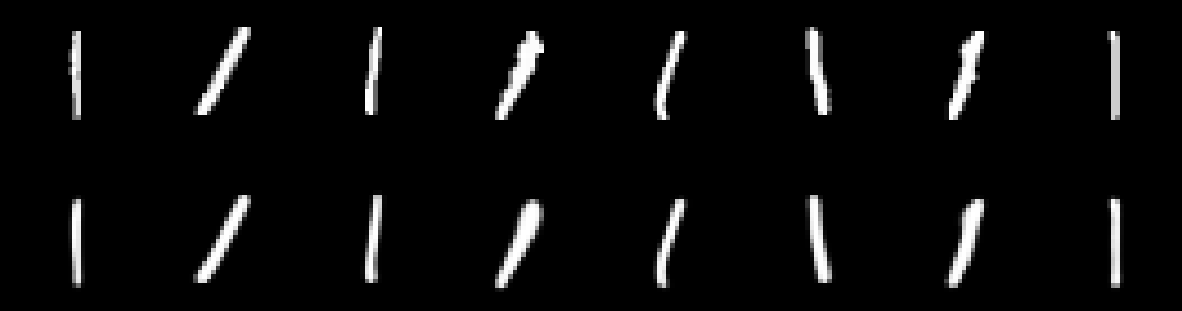

Epoch 5: 100%|██████████| 163/163 [00:18<00:00,  8.96it/s, v_num=nary, train_total_step=1.79e+3, train_recon_step=1.76e+3, train_kld_step=30.90, train_total_epoch=2.87e+3, train_recon_epoch=2.82e+3, train_kld_epoch=50.70]

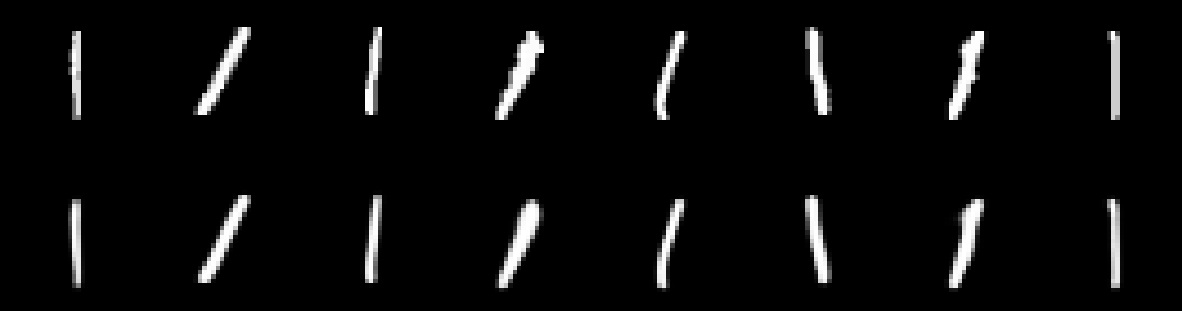

Epoch 6: 100%|██████████| 163/163 [00:18<00:00,  8.79it/s, v_num=nary, train_total_step=1.61e+3, train_recon_step=1.58e+3, train_kld_step=29.20, train_total_epoch=2.81e+3, train_recon_epoch=2.76e+3, train_kld_epoch=50.40]

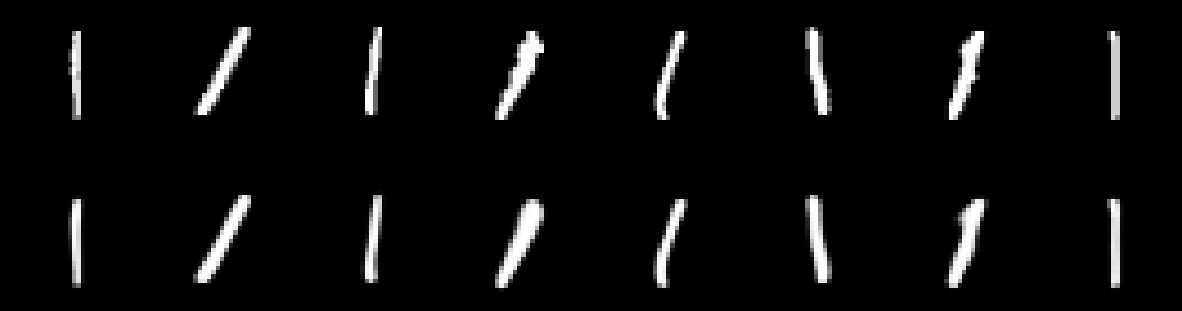

Epoch 7: 100%|██████████| 163/163 [00:19<00:00,  8.52it/s, v_num=nary, train_total_step=1.57e+3, train_recon_step=1.54e+3, train_kld_step=29.00, train_total_epoch=2.76e+3, train_recon_epoch=2.71e+3, train_kld_epoch=50.50]

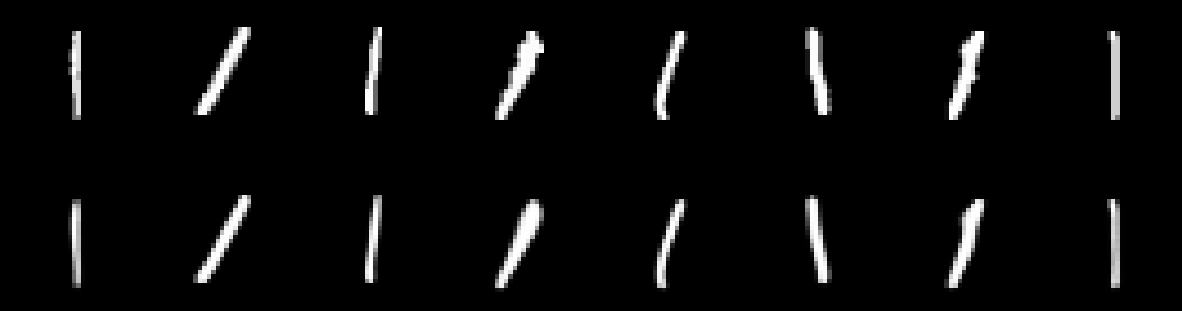

Epoch 8: 100%|██████████| 163/163 [00:17<00:00,  9.33it/s, v_num=nary, train_total_step=1.63e+3, train_recon_step=1.6e+3, train_kld_step=29.60, train_total_epoch=2.73e+3, train_recon_epoch=2.68e+3, train_kld_epoch=50.10] 

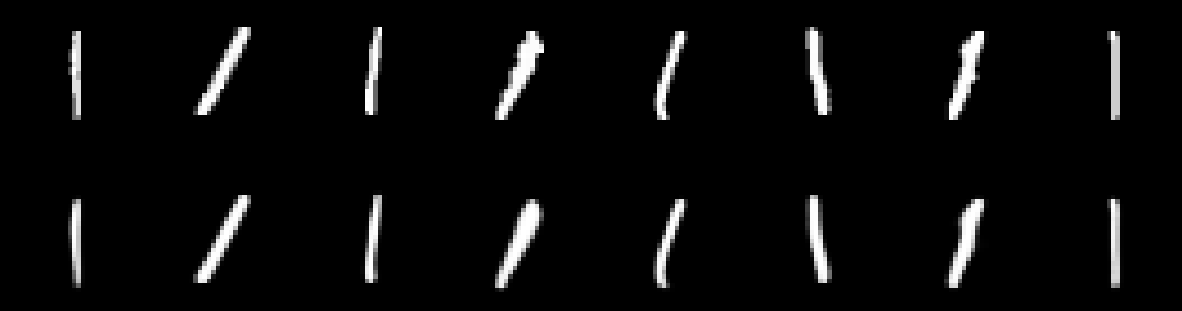

Epoch 9: 100%|██████████| 163/163 [00:17<00:00,  9.47it/s, v_num=nary, train_total_step=1.67e+3, train_recon_step=1.64e+3, train_kld_step=30.50, train_total_epoch=2.72e+3, train_recon_epoch=2.67e+3, train_kld_epoch=50.50]

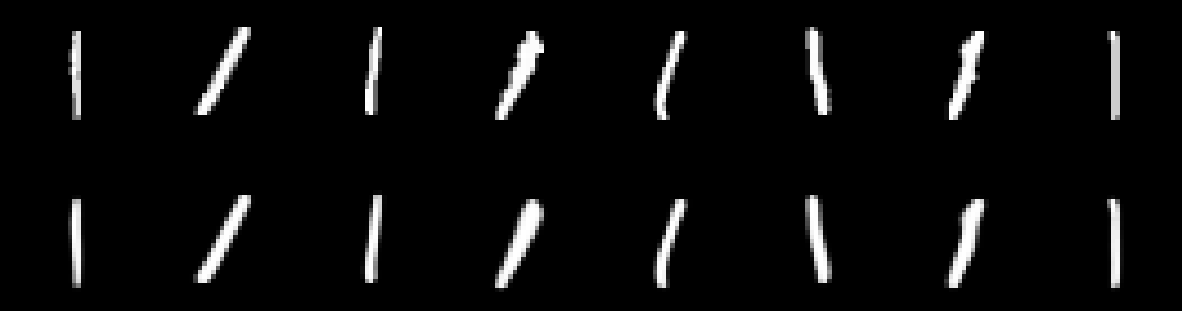

Epoch 10: 100%|██████████| 163/163 [00:17<00:00,  9.41it/s, v_num=nary, train_total_step=1.52e+3, train_recon_step=1.49e+3, train_kld_step=28.20, train_total_epoch=2.67e+3, train_recon_epoch=2.62e+3, train_kld_epoch=50.10]

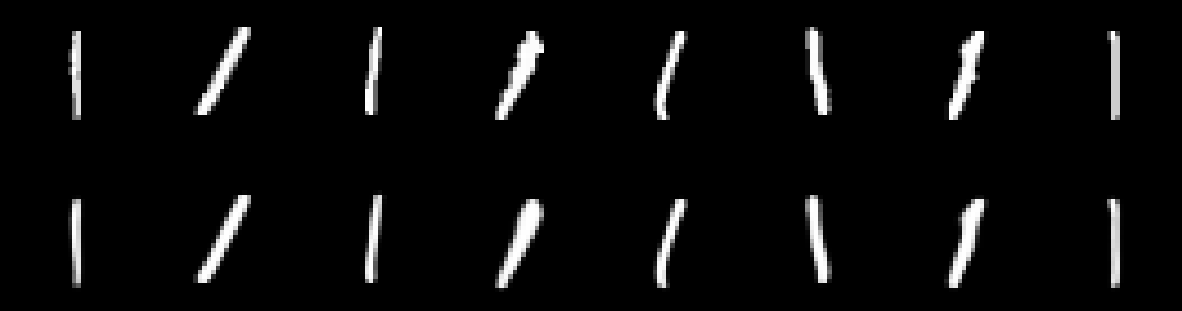

Epoch 11: 100%|██████████| 163/163 [00:17<00:00,  9.46it/s, v_num=nary, train_total_step=1.71e+3, train_recon_step=1.68e+3, train_kld_step=29.70, train_total_epoch=2.67e+3, train_recon_epoch=2.62e+3, train_kld_epoch=49.90]

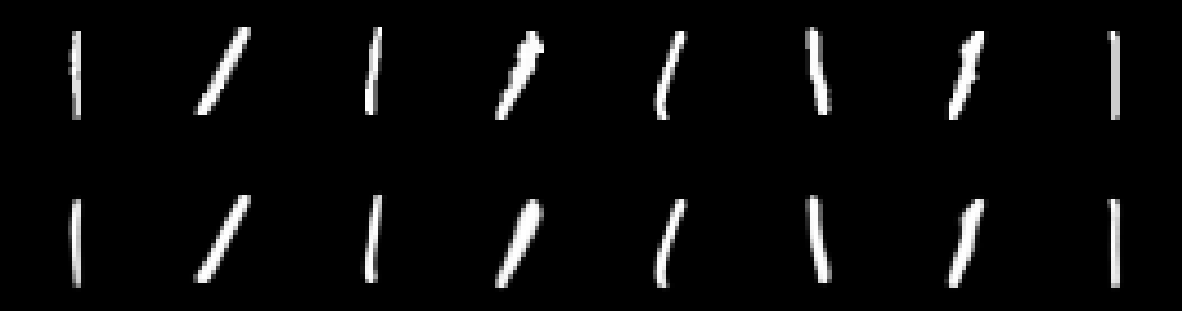

Epoch 12: 100%|██████████| 163/163 [00:17<00:00,  9.46it/s, v_num=nary, train_total_step=1.61e+3, train_recon_step=1.58e+3, train_kld_step=29.80, train_total_epoch=2.64e+3, train_recon_epoch=2.59e+3, train_kld_epoch=49.90]

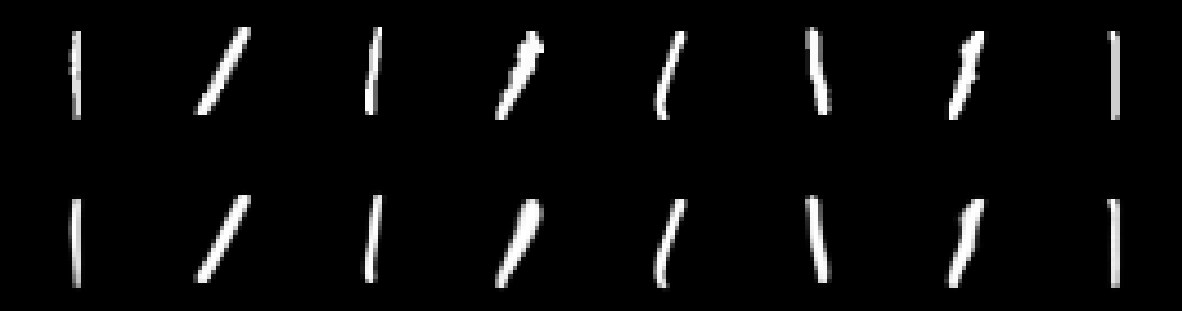

Epoch 13: 100%|██████████| 163/163 [00:16<00:00,  9.65it/s, v_num=nary, train_total_step=1.48e+3, train_recon_step=1.45e+3, train_kld_step=28.60, train_total_epoch=2.62e+3, train_recon_epoch=2.57e+3, train_kld_epoch=49.80]

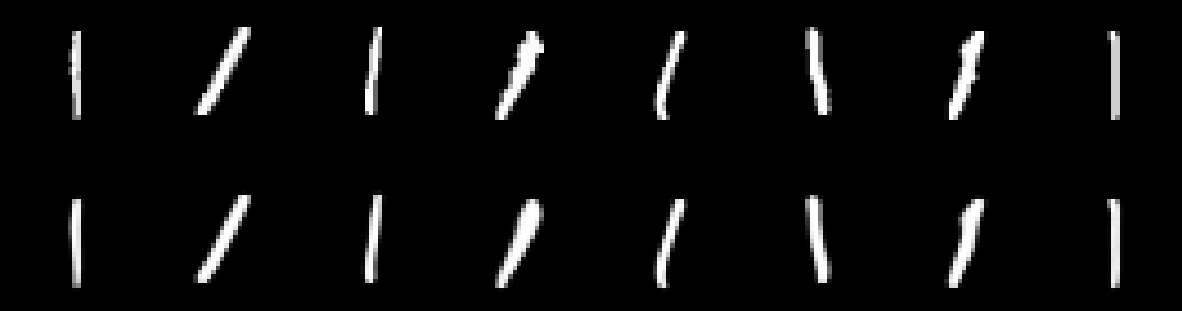

Epoch 14: 100%|██████████| 163/163 [00:17<00:00,  9.28it/s, v_num=nary, train_total_step=1.5e+3, train_recon_step=1.47e+3, train_kld_step=28.50, train_total_epoch=2.62e+3, train_recon_epoch=2.57e+3, train_kld_epoch=49.60] 

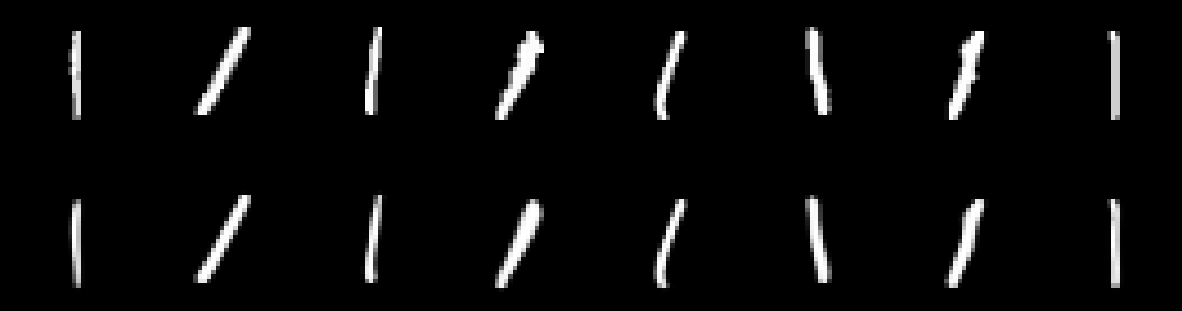

Epoch 14: 100%|██████████| 163/163 [00:18<00:00,  8.90it/s, v_num=nary, train_total_step=1.5e+3, train_recon_step=1.47e+3, train_kld_step=28.50, train_total_epoch=2.59e+3, train_recon_epoch=2.54e+3, train_kld_epoch=49.40]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 163/163 [00:18<00:00,  8.87it/s, v_num=nary, train_total_step=1.5e+3, train_recon_step=1.47e+3, train_kld_step=28.50, train_total_epoch=2.59e+3, train_recon_epoch=2.54e+3, train_kld_epoch=49.40]


In [9]:
trainer.fit(model=lwrapper, 
            train_dataloaders=train_loader, 
            val_dataloaders=val_loader)